# Installing dependencies

In [12]:
# !pip install langchain -q
# !pip install openai -q
# !pip install PyPDF2 -q
# !pip install faiss-cpu -q
# !pip install tiktoken -q
# !pip install python-dotenv -q
# !pip install langchain_openai -q
# !pip install chromadb -q
# !pip install beautifulsoup4 -q
# !pip install playwright -q
# !playwright install
# !pip install unstructured -q
# !pip install html2text -q
# !pip install clean-text -q
# !pip uninstall emoji -y -q
# !pip install emoji==1.7 -q
# !pip install Unidecode -q
# !pip install spacy -q
# !python -m spacy download en_core_web_lg
# !python -m spacy download es_core_news_lg
# !pip install scikit-learn -q
# !pip install matplotlib -q
# !pip install yellowbrick   -q

# API KEYS

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

# Sources

## Harm Reduction association

In [1]:
from PyPDF2 import PdfReader
from langchain.docstore.document import Document

In [2]:
SOURCES = "./sources/"
PRINCIPLES = "NHRC-PDF-Principles_Of_Harm_Reduction.pdf"

In [3]:
pdf_reader = PdfReader(SOURCES + PRINCIPLES)

In [4]:
principles_text = ""
for page in pdf_reader.pages:
    text = page.extract_text()
    if text:
        principles_text += text


principles_doc =  Document(page_content=principles_text, metadata={"source": "https://harmreduction.org/about-us/principles-of-harm-reduction/", "lang":"en"})


## El gato y la caja

In [5]:
import requests
from bs4 import BeautifulSoup
 
 
url = 'https://elgatoylacaja.com/sobredrogas/indice'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
 
urls = []
for link in soup.find_all('a'):
    if link.get('href') == "/potencial-cientifico-terapeutico-de-los-psicodelicos":
        urls.append("https://elgatoylacaja.com" + link.get('href').replace("sobredrogas",""))
    else:
        urls.append("https://elgatoylacaja.com/sobredrogas" + link.get('href').replace("sobredrogas",""))

In [6]:
from langchain_community.document_loaders import UnstructuredURLLoader

loader = UnstructuredURLLoader(urls=urls)
data = loader.load()

In [7]:
from langchain_community.document_transformers import Html2TextTransformer

html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(data)

for doc in docs_transformed:
    doc.metadata["lang"] = "es"

docs_transformed += [principles_doc]

# Chunking

In [8]:
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain.text_splitter import SpacyTextSplitter
from cleantext import clean

In [37]:
for doc in docs_transformed:

        if doc.metadata["lang"] == "en":
            sep_docs = en.split_documents([doc])
        elif doc.metadata["lang"] == "es":
            sep_docs = es.split_documents([doc])

/home/franco/Documents/Proyectos/harm-reduction-chatbot/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [40]:

def cleaner(doc):
    text = doc.page_content
    cleaned_text = clean(text,
    fix_unicode=True,               
    lower=True,                     
    no_line_breaks=True,           
    no_urls=True,                  
    no_emails=True,                
    no_punct=True,                 
    replace_with_punct="",          
    replace_with_url="",
    replace_with_email="",
    lang="en"
)
    # cleaned_text = clean(text, clean_html=True, clean_special_chars=True,clean_non_text=True, no_line_breaks=False)
    doc.page_content = cleaned_text
    return doc
en = SpacyTextSplitter(pipeline="en_core_web_lg")
es = SpacyTextSplitter(pipeline="es_core_news_lg") 
def split_and_clean(docs):
    new_docs = []
    for doc in docs:

        if doc.metadata["lang"] == "en":
            sep_docs = en.split_documents([doc])
        elif doc.metadata["lang"] == "es":
            sep_docs = es.split_documents([doc])

        cleaned_docs = list(map(cleaner, sep_docs))
        new_docs += cleaned_docs
    return new_docs
    

In [ ]:

splitted_docs = split_and_clean(docs_transformed)

# Vector DB

In [3]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [4]:
embeddings = OpenAIEmbeddings() # Embeddings model
vectordb = Chroma(persist_directory="./chroma_db", embedding_function=embeddings)
retriever = vectordb.as_retriever(search_kwargs={"k": 7})

/home/franco/Documents/Proyectos/harm-reduction-chatbot/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
# Create the database
# vectordb = Chroma.from_documents(documents=splitted_docs, embedding=OpenAIEmbeddings(), persist_directory="./chroma_db")
# retriever = vectordb.as_retriever(search_kwargs={"k": 7})

In [9]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

There are some chunks which contains comments and citation. Since there is no information to respond questions about drugs in these chunks they should be eliminated. First Let's if we can find them automatically with tsne and outlier detection

In [238]:

X = np.array(vectordb._collection.get(include=['embeddings'])["embeddings"], dtype=np.float32)
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)


Text(0, 0.5, 'TSNE2')

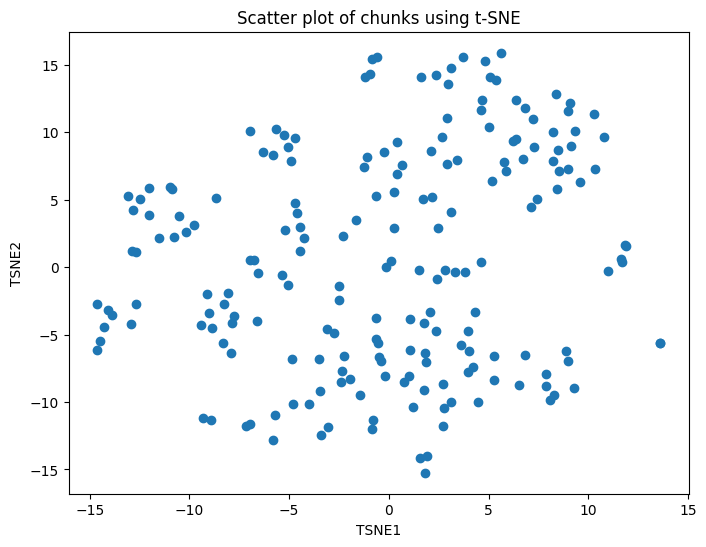

In [11]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
ax.scatter(tsne_results.T[0], tsne_results.T[1])
plt.title('Scatter plot of chunks using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')


In [74]:
!pip install cleanlab -q

In [76]:
from cleanlab.outlier import OutOfDistribution

In [118]:
ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=X)

Fitting OOD estimator based on provided features ...


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
         2.,  4.,  4., 13., 14., 22., 26., 29., 32., 25., 12.,  9.]),
 array([0.80428714, 0.80935955, 0.81443197, 0.81950438, 0.82457674,
        0.82964915, 0.83472157, 0.83979398, 0.84486639, 0.84993881,
        0.85501117, 0.86008358, 0.86515599, 0.87022841, 0.87530082,
        0.88037324, 0.88544559, 0.89051801, 0.89559042, 0.90066284,
        0.90573525, 0.91080767, 0.91588002, 0.92095244, 0.92602485,
        0.93109727]),
 <BarContainer object of 25 artists>)

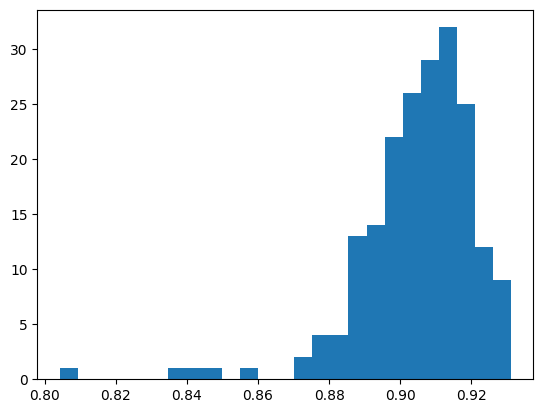

In [119]:
plt.hist(train_outlier_scores, bins=25)

I could not find a consistent way to eliminate the undesired chunks, but since there are not too many and there is no need to read the entire chunk to decide if it is necessary to remove it or not I will check each manually.

In [20]:
docs = vectordb._collection.get(include=['documents'])["documents"]
ids = vectordb._collection.get(include=['documents'])["ids"]

In [245]:
import pandas as pd

df = pd.DataFrame({"text": docs, "ids": ids})


197

In [247]:
ids_to_remove = [0,3,4,5,17,31, 45, 67, 88, 97, 118, 126, 132, 140, 151, 158, 167, 172, 180, 185]

In [241]:
df.set_index("ids", inplace=True)

In [248]:
df.drop(index=ids_to_remove, inplace=True)

In [ ]:
from langchain_community.document_loaders import DataFrameLoader
loader = DataFrameLoader(df, page_content_column="text")


In [34]:
# Load database
embeddings = OpenAIEmbeddings() # Embeddings model
vectordb = Chroma(persist_directory="./chroma_db", embedding_function=embeddings)


retriever = vectordb.as_retriever(search_type='similarity',search_kwargs={"k":7})

In [ ]:
# Create the database
# vectordb = Chroma.from_documents(documents=loader.load(), embedding=OpenAIEmbeddings(), persist_directory="./chroma_db")
# retriever = vectordb.as_retriever(search_kwargs={"k": 7, "score_threshold": 0.5})

# Chain

In [8]:
from langchain.llms import OpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.memory import ConversationBufferMemory



In [28]:

template = """You are a harm reduction chatbot. You only should answer question about drugs based only on the given sources. Never recommend taking anything and if needed recommend seing a doctor or a speciallist:
sources: 
{context}

Question: {question}

The chat history between you and the user might give you context about what the user is looking for:
Chat history: {chat_history}

Answer always in the language of the question
"""
prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


Sometimes the chunks contains a lot of irrelevant information, so a contextual compression retriever is applied

In [29]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [31]:
from langchain_core.runnables import RunnableParallel

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


def format_docs(docs):

    return "\n\n".join(doc.page_content for doc in docs)

def get_memory(memory):
    history = memory["chat_history"]
    l = []
    if history:
        for n, message in enumerate(history):
            if n % 2 == 0:
                l.append(f"Human: {message.content}")
            else:
                l.append(f"AI: {message.content}")
            
        return "\n\n".join(l)
    else:
        return ""

rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | RunnablePassthrough.assign(history=(lambda x: get_memory(x["chat_history"])))
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": compression_retriever, "question": RunnablePassthrough(), "chat_history": memory.load_memory_variables}
).assign(answer=rag_chain_from_docs)



Let's try a basic question

In [ ]:
output = rag_chain_with_source.invoke("What are the harm reduction principles?")


In [ ]:
output

{'context': [Document(page_content='foundational principles central to harm reduction harm reduction is a set of practical strategies and ideas aimed at reducing negative consequences associated with drug use harm reduction is also a movement for social justice built on a belief in and respect for the rights of people who use drugs harm reduction incorporates a spectrum of strategies that includes safer use managed use abstinence meeting people who use drugs where theyre at and addressing conditions of use along with the use itself because harm reduction demands that interventions and policies designed to serve people who use drugs reflect specific individual and community needs there is no universal definition of or formula for implementing harm reduction however national harm reduction coalition considers the following principles central to harm reduction practice calls for the nonjudgmental noncoercive provision of services and resources to people who use drugs and the communities i

The documents retrieved are those related to the query. Now lets save the answer in the memory:

In [299]:
memory.save_context({"input":output["question"]}, {"output": output["answer"]})

If it is working then, the model should know what my last question was

In [300]:
rag_chain_with_source.invoke("What was my last question?")

{'context': [Document(page_content='police bystanders other participants how does the person present to these people how will they react case study jessica jessica has been using heroin on and off for the past 10 years jessica stopped using for a few months while she was with her ex but they recently broke up she is feeling depressed and anxious and is looking to use again she buys a bag and heads to the syringe exchange for some new points and heads to her encampment in a rush for more resources visit harmreductionorg harmreductioncoalitionrevised 2020 harmreductioncoalition harmreduction harmreduction', metadata={'lang': 'en', 'source': 'https://harmreduction.org/about-us/principles-of-harm-reduction/'}),
  Document(page_content='comentario enviadotu comentario fue publicado muchas gracias ha ocurrido un errorcampos incompletos intente nuevamente que te parecio la nota', metadata={'lang': 'es', 'source': 'https://elgatoylacaja.com/sobredrogas/bases-neurofisiologicas-de-la-adiccion'})

Now we will try more complex questions in spanish

In [322]:
memory.clear()

In [323]:
output = rag_chain_with_source.invoke("cuáles son los principios de la reducción de daños?")
memory.save_context({"input":output["question"]}, {"output": output["answer"]})
print(output["answer"])

Los principios de la reducción de daños incluyen minimizar los riesgos y los daños asociados al consumo de drogas, brindar información y educación sobre el uso de sustancias, contemplar las circunstancias individuales y comunitarias de una región, y promover políticas basadas en evidencia científica.


In [324]:
output = rag_chain_with_source.invoke("Qué es el paco?")
memory.save_context({"input":output["question"]}, {"output": output["answer"]})
print(output["answer"])

El paco es una forma de cocaina fumable que se obtiene a partir de las hojas de coca y otros componentes químicos. Es un producto con menos pureza que la cocaina y puede contener sustancias peligrosas como ácido de baterías, broncodilatadores, cafeína, solventes, amoniaco, queroseno, entre otros. Su composición puede variar según la región donde circule, lo que aumenta los riesgos para la salud de quienes lo consumen.


In [325]:

output = rag_chain_with_source.invoke("Es lo mismo que el crack?")
memory.save_context({"input":output["question"]}, {"output": output["answer"]})
print(output["answer"])

No, el crack es una forma de consumir la cocaína de manera fumada, mientras que el paco es una forma de cocaína fumable que se obtiene a partir de las hojas de coca y otros componentes químicos. Ambas son sustancias peligrosas con riesgos para la salud.


In [328]:
output = rag_chain_with_source.invoke("La marihuana puede causar adiccion?")
memory.save_context({"input":output["question"]}, {"output": output["answer"]})
print(output["answer"])

Sí, la marihuana puede causar adicción. Según estudios, se estima que alrededor del 9% de los usuarios que comienzan a consumir marihuana pueden desarrollar algún problema de dependencia a lo largo de su vida. Además, el riesgo de entrar en un consumo adictivo de marihuana se incrementa significativamente si el consumo es diario y varias veces al día. Es importante tener en cuenta que la adicción a la marihuana puede manifestarse con deseos compulsivos de consumir, dedicar mucho tiempo y recursos a buscar la droga, y experimentar síntomas de abstinencia al intentar dejar de consumirla.


In [329]:
output = rag_chain_with_source.invoke("Es seguro consumir LSD?")
memory.save_context({"input":output["question"]}, {"output": output["answer"]})
print(output["answer"])

Basándonos en las fuentes proporcionadas, el consumo de LSD conlleva riesgos asociados, como la posibilidad de tener un "mal viaje" que pueda resultar en un accidente o una experiencia traumática a corto o largo plazo. Además, el consumo de LSD en personas con trastornos psiquiátricos como psicosis o esquizofrenia puede inducir o empeorar estas condiciones. Aunque el LSD no se considera una sustancia adictiva, su consumo frecuente puede generar tolerancia y disminuir la potencia de sus efectos. También existe el riesgo legal, ya que en la mayoría de los países el LSD está penado por la ley. En resumen, el consumo de LSD no es seguro y puede tener consecuencias negativas para la salud y la vida de las personas. Si tienes dudas o necesitas más información, es recomendable consultar a un especialista.
